# Sales Forecast and analysis

## Quod Financial Technical Test

> Done by **Tristan PERROT**


## Import libraries


In [ ]:
import os
import sys

import dash
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import tensorflow as tf
from dash import dcc, html
from dash.dependencies import Input, Output
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

pio.renderers.default = "vscode"

## Import Data

In [4]:
# DATA_DIR = '..' + os.sep + 'data'
DATA_DIR = 'data-quod'

transactions_1 = pd.read_csv(DATA_DIR + os.sep + 'transactions_1.csv', index_col=0, parse_dates=['date'])
transactions_2 = pd.read_csv(DATA_DIR + os.sep + 'transactions_2.csv', index_col=0, parse_dates=['date'])

In [5]:
transactions_1

,customer_id,product_id,date
0,8649525,Opel,2017-01-31 09:31:08.873000+00:00
1,8649525,Volkswagen,2017-02-03 16:59:16.610000+00:00
2,8649525,Volkswagen,2017-02-05 19:47:55.353000+00:00
3,8649525,Volkswagen,2017-02-05 19:48:14.633000+00:00
4,8649525,Volkswagen,2017-02-06 09:59:49.053000+00:00
...,...,...,...
499995,8822663,Fiat,2019-12-17 10:15:10.907000+00:00
499996,8822663,Renault,2017-09-26 08:00:46.090000+00:00
499997,8822663,Renault,2017-09-26 08:17:36.350000+00:00
499998,8822663,Renault,2017-09-26 09:05:09.700000+00:00


In [6]:
transactions_2

,customer_id,product_id,date
500000,8822663,Abarth,2018-06-28 09:19:11.130000+00:00
500001,8822663,Peugeot,2019-07-17 08:06:29.500000+00:00
500002,8822663,Nissan,2017-06-22 07:29:22.440000+00:00
500003,8822663,Nissan,2017-06-22 07:50:10.863000+00:00
500004,8822663,Nissan,2017-06-22 08:40:35.923000+00:00
...,...,...,...
975950,1111821,Renault,2019-05-17 10:06:43.037000+00:00
975951,4232782,Renault,2017-10-27 17:49:54.483000+00:00
975952,4746355,Seat,2019-01-09 16:31:08.133000+00:00
975953,4743766,Opel,2017-03-29 16:25:05.907000+00:00


In [7]:
transactions_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 499999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   customer_id  500000 non-null  int64              
 1   product_id   500000 non-null  object             
 2   date         500000 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(1), object(1)
memory usage: 15.3+ MB


In [8]:
all_transactions = pd.concat([transactions_1, transactions_2])

In [9]:
unique_products = all_transactions['product_id'].unique()
unique_products

array(['Opel', 'Volkswagen', 'BMW', 'Abarth', 'Audi', 'Seat', 'Peugeot',
       'Mercedes Benz', 'Renault', 'Lancia', 'Fiat', 'Skoda', 'Toyota',
       'Citroen', 'Nissan', 'Ssangyong', 'Volvo', 'Jaguar', 'Ford',
       'Alfa Romeo', 'DS', 'Mini', 'Lexus', 'Mazda', 'Kia', 'Hyundai',
       'Jeep', 'Land Rover', 'Chevrolet', 'Infiniti', 'Honda', 'Dacia',
       'Tesla', 'Mitsubishi', 'Subaru', 'Iveco', 'Porsche', 'Suzuki',
       'Chrysler', 'Undefined', 'Piaggio', 'Yamaha', 'Isuzu',
       'Not a make', '├ÅTS', 'Harley-Davidson', 'Tata', 'MCC/Smart',
       'Equipe', 'Oxygen'], dtype=object)

## Data Analysis

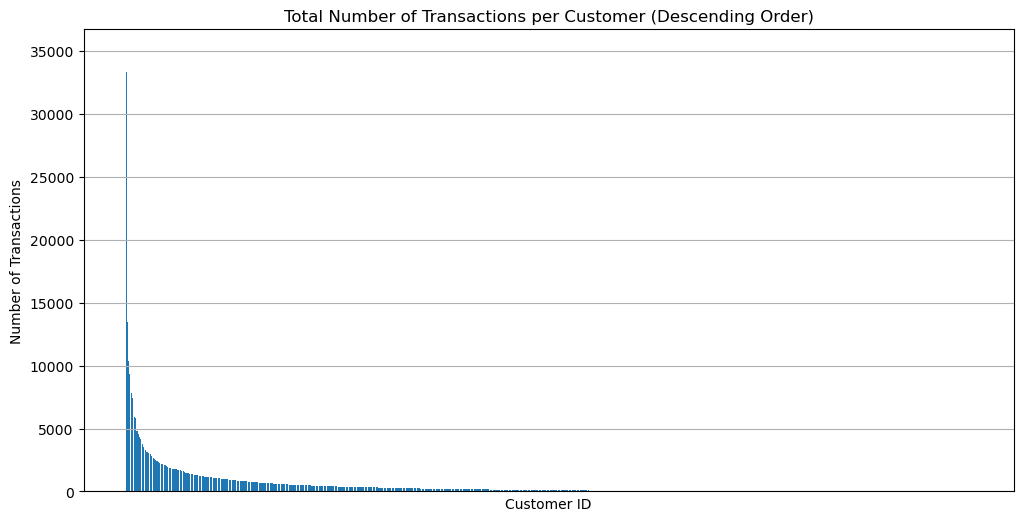

In [10]:
# Combine transactions and count the number per customer
transactions_per_customer = pd.concat([transactions_1, transactions_2]).groupby('customer_id').size()

# Sort in descending order
transactions_per_customer = transactions_per_customer.sort_values(ascending=False)

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(transactions_per_customer.index.astype(str), transactions_per_customer.values)

# Labels and title
plt.xlabel("Customer ID")  # Remove x-axis label text
plt.ylabel("Number of Transactions")
plt.title("Total Number of Transactions per Customer (Descending Order)")
plt.grid(axis='y')

# Remove x-axis ticks and labels for readability
plt.xticks([], []) 

# Show the plot
plt.show()

In [11]:
# Initialize Dash app
app = dash.Dash(__name__)

# Layout
app.layout = html.Div([
    dcc.Dropdown(
        id='product-dropdown',
        options=[{'label': p, 'value': p} for p in all_transactions['product_id'].unique()],
        value=all_transactions['product_id'].unique()[0],
        clearable=False
    ),
    dcc.Graph(id='product-transaction-plot')
])

# Callback to update the plot
@app.callback(
    Output('product-transaction-plot', 'figure'),
    Input('product-dropdown', 'value')
)
def update_graph(product_id):
    # Filter transactions for the selected product
    transactions_2018 = all_transactions[
        (all_transactions['date'].dt.year == 2018) & (all_transactions['product_id'] == product_id)
    ]

    # Group by month
    transactions_2018_per_month = transactions_2018.groupby(transactions_2018['date'].dt.month).size().reset_index()
    transactions_2018_per_month.columns = ['Month', 'Number of Transactions']

    # Map month numbers to names
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    transactions_2018_per_month['Month'] = transactions_2018_per_month['Month'].apply(lambda x: month_names[x-1])

    # Create the figure
    fig = px.bar(
        transactions_2018_per_month,
        x="Month",
        y="Number of Transactions",
        title=f"Transaction Frequency per Month for {product_id} in 2018",
        labels={"Month": "Month", "Number of Transactions": "Transaction Count"},
        text="Number of Transactions"
    )
    
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8000)

## Prediction model

### Random Forest Model

In [12]:
model_choice = 'RF'
prediction_start_date = '2019-02-01'

#### Preprocessing

In [13]:
# Ensure date is in datetime format and remove timezone if needed
all_transactions['date'] = pd.to_datetime(all_transactions['date']).dt.tz_localize(None)

# Create a 'month' column for monthly aggregations
all_transactions['month'] = all_transactions['date'].dt.to_period('M')

# Aggregate transactions per customer and month
df_features = all_transactions.groupby(['customer_id', 'month']).size().reset_index(name='num_transactions')

# Convert month to datetime for modeling
df_features['month'] = df_features['month'].dt.to_timestamp()

In [14]:
df_features

,customer_id,month,num_transactions
0,1001614,2018-06-01,28
1,1001614,2018-09-01,3
2,1001614,2018-10-01,19
3,1001614,2019-01-01,4
4,1001614,2019-02-01,8
...,...,...,...
28140,9996357,2018-04-01,6
28141,9996357,2018-05-01,9
28142,9996357,2018-09-01,2
28143,9996357,2018-12-01,1


#### Feature Engineering

In [15]:
# Generate lag features for past transactions (1 to 3 months)
for lag in range(1, 4):
    df_features[f'lag_{lag}'] = df_features.groupby('customer_id')['num_transactions'].shift(lag)

# Rolling Aggregates (3-month rolling mean & sum)
df_features['rolling_mean_3m'] = df_features.groupby('customer_id')['num_transactions'].shift().rolling(window=3).mean()
df_features['rolling_sum_3m'] = df_features.groupby('customer_id')['num_transactions'].shift().rolling(window=3).sum()

# One-hot encode month (seasonality indicators)
df_features['month_num'] = df_features['month'].dt.month
df_features = pd.get_dummies(df_features, columns=['month_num'], prefix='month', drop_first=True)

# Recency feature: Days since last transaction
df_features['recency'] = (df_features['month'] - df_features.groupby('customer_id')['month'].shift(1)).dt.days

# Drop rows with missing values (from lag/rolling calculations)
df_features.dropna(inplace=True)


In [16]:
df_features

,customer_id,month,num_transactions,lag_1,lag_2,lag_3,rolling_mean_3m,rolling_sum_3m,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,recency
3,1001614,2019-01-01,4,19.0,3.0,28.0,16.666667,50.0,0,0,0,0,0,0,0,0,0,0,0,92.0
4,1001614,2019-02-01,8,4.0,19.0,3.0,8.666667,26.0,1,0,0,0,0,0,0,0,0,0,0,31.0
5,1001614,2019-03-01,8,8.0,4.0,19.0,10.333333,31.0,0,1,0,0,0,0,0,0,0,0,0,28.0
6,1001614,2019-04-01,13,8.0,8.0,4.0,6.666667,20.0,0,0,1,0,0,0,0,0,0,0,0,31.0
7,1001614,2019-05-01,11,13.0,8.0,8.0,9.666667,29.0,0,0,0,1,0,0,0,0,0,0,0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28139,9996357,2018-03-01,10,5.0,9.0,16.0,10.000000,30.0,0,1,0,0,0,0,0,0,0,0,0,28.0
28140,9996357,2018-04-01,6,10.0,5.0,9.0,8.000000,24.0,0,0,1,0,0,0,0,0,0,0,0,31.0
28141,9996357,2018-05-01,9,6.0,10.0,5.0,7.000000,21.0,0,0,0,1,0,0,0,0,0,0,0,30.0
28142,9996357,2018-09-01,2,9.0,6.0,10.0,8.333333,25.0,0,0,0,0,0,0,0,1,0,0,0,123.0


#### Prepare data for model

In [17]:
# Define input features and target variable
X = df_features.drop(columns=['customer_id', 'month', 'num_transactions'])
y = df_features['num_transactions']

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Train the model (Random Forest Regressor)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Display results
performance_metrics = pd.DataFrame({
    "Metric": ["Mean Absolute Error (MAE)", "Root Mean Squared Error (RMSE)"],
    "Value": [mae, rmse]
})

In [18]:
performance_metrics

,Metric,Value
0,Mean Absolute Error (MAE),26.245308
1,Root Mean Squared Error (RMSE),67.106682


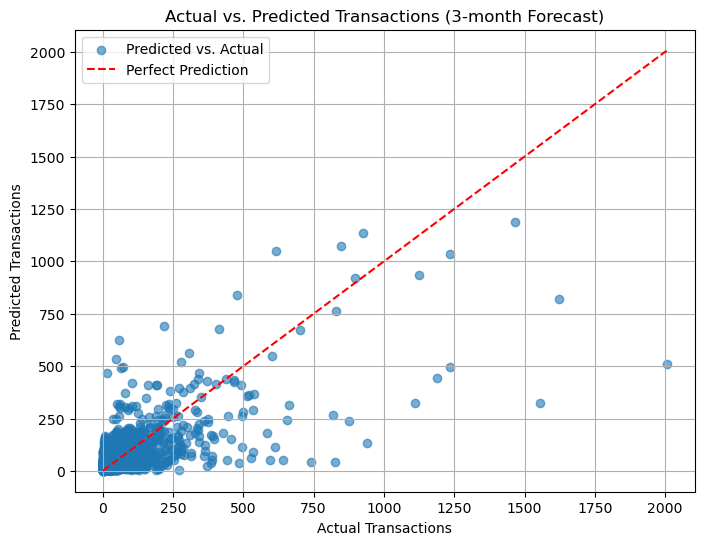

In [19]:
# Scatter plot for actual vs. predicted transactions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, label="Predicted vs. Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Prediction")
plt.xlabel("Actual Transactions")
plt.ylabel("Predicted Transactions")
plt.title("Actual vs. Predicted Transactions (3-month Forecast)")
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

### LSTM model

Epoch 1/30
664/664 [==============================] - 4s 4ms/step - loss: 8.2853e-04 - mae: 0.0129 - val_loss: 3.2023e-04 - val_mae: 0.0104
Epoch 2/30
664/664 [==============================] - 2s 3ms/step - loss: 7.5592e-04 - mae: 0.0124 - val_loss: 2.8769e-04 - val_mae: 0.0100
Epoch 3/30
664/664 [==============================] - 2s 3ms/step - loss: 7.1473e-04 - mae: 0.0119 - val_loss: 3.0692e-04 - val_mae: 0.0118
Epoch 4/30
664/664 [==============================] - 2s 3ms/step - loss: 5.8855e-04 - mae: 0.0112 - val_loss: 2.7490e-04 - val_mae: 0.0092
Epoch 5/30
664/664 [==============================] - 2s 3ms/step - loss: 5.8313e-04 - mae: 0.0111 - val_loss: 2.8225e-04 - val_mae: 0.0094
Epoch 6/30
664/664 [==============================] - 2s 3ms/step - loss: 6.0799e-04 - mae: 0.0115 - val_loss: 2.5480e-04 - val_mae: 0.0075
Epoch 7/30
664/664 [==============================] - 2s 3ms/step - loss: 5.7940e-04 - mae: 0.0110 - val_loss: 2.4981e-04 - val_mae: 0.0085
Epoch 8/30
664/664 [

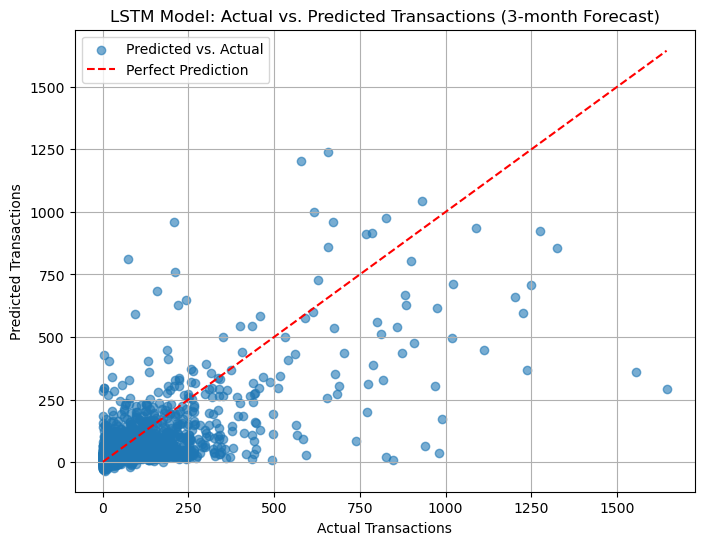

In [25]:
# ------------------ LOAD DATA ------------------ #
# Assuming `df_features` is already created as per previous processing
df = df_features.copy()

# Select relevant columns for modeling
df = df[['customer_id', 'month', 'num_transactions', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3m', 'rolling_sum_3m', 'recency']]

# Normalize transaction-related features
scaler = MinMaxScaler()
df[['num_transactions', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3m', 'rolling_sum_3m', 'recency']] = scaler.fit_transform(
    df[['num_transactions', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3m', 'rolling_sum_3m', 'recency']]
)

# ------------------ CREATE TIME SERIES SEQUENCES ------------------ #
def create_sequences(data, seq_length=3):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length, 2:].values)  # Select feature columns
        y.append(data.iloc[i+seq_length, 2])  # Target variable (num_transactions)
    return np.array(X), np.array(y)

# Train-test split with cutoff date
cutoff_date = '2018-09-01'
train_data = df[df['month'] < cutoff_date]
test_data = df[df['month'] >= cutoff_date]

# Create sequences for LSTM model
sequence_length = 3
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# ------------------ RESHAPE DATA FOR LSTM ------------------ #
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# ------------------ BUILD LSTM MODEL ------------------ #
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, X.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Output layer
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ------------------ TRAIN MODEL ------------------ #
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

# ------------------ PREDICT ------------------ #
y_pred = model.predict(X_test)

# Reverse scaling
y_test_unscaled = scaler.inverse_transform(np.c_[y_test, np.zeros((len(y_test), X.shape[2] - 1))])[:, 0]
y_pred_unscaled = scaler.inverse_transform(np.c_[y_pred, np.zeros((len(y_pred), X.shape[2] - 1))])[:, 0]

# ------------------ EVALUATE MODEL ------------------ #
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# ------------------ VISUALIZE RESULTS ------------------ #
plt.figure(figsize=(8, 6))
plt.scatter(y_test_unscaled, y_pred_unscaled, alpha=0.6, label="Predicted vs. Actual")
plt.plot([min(y_test_unscaled), max(y_test_unscaled)], [min(y_test_unscaled), max(y_test_unscaled)], color='red', linestyle='--', label="Perfect Prediction")
plt.xlabel("Actual Transactions")
plt.ylabel("Predicted Transactions")
plt.title("LSTM Model: Actual vs. Predicted Transactions (3-month Forecast)")
plt.legend()
plt.grid(True)
plt.show()

## Data analysis

### Compute Sales per Product Over the Last 6 Months

In [48]:
# Convert date to datetime format if not already
all_transactions['date'] = pd.to_datetime(all_transactions['date'])

# Define function to get top 5 products for any given date
def top_products_last_six_months(reference_date):
    # Ensure reference_date has the same timezone as the date column
    reference_date = reference_date.tz_localize('UTC')
    
    # Filter transactions for the last 6 months from reference date
    start_date = reference_date - pd.DateOffset(months=6)
    recent_transactions = all_transactions[
        (all_transactions['date'] >= start_date) & (all_transactions['date'] <= reference_date)
    ]

    # Count sales per product
    product_sales = recent_transactions.groupby('product_id').size().reset_index(name='sales')

    # Get top 5 products
    top_5_products = product_sales.nlargest(5, 'sales')

    return top_5_products

# Example usage: Get top products for July 2019
top_products = top_products_last_six_months(pd.Timestamp("2019-07-31"))
print(top_products)

    product_id  sales
30     Renault  22047
38  Volkswagen   9695
27     Peugeot   9578
2         Audi   9170
3          BMW   8413


/var/folders/76/ktnqnwjn3kz2zdhpgy_03fww0000gn/T/ipykernel_88421/1504309752.py:2: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



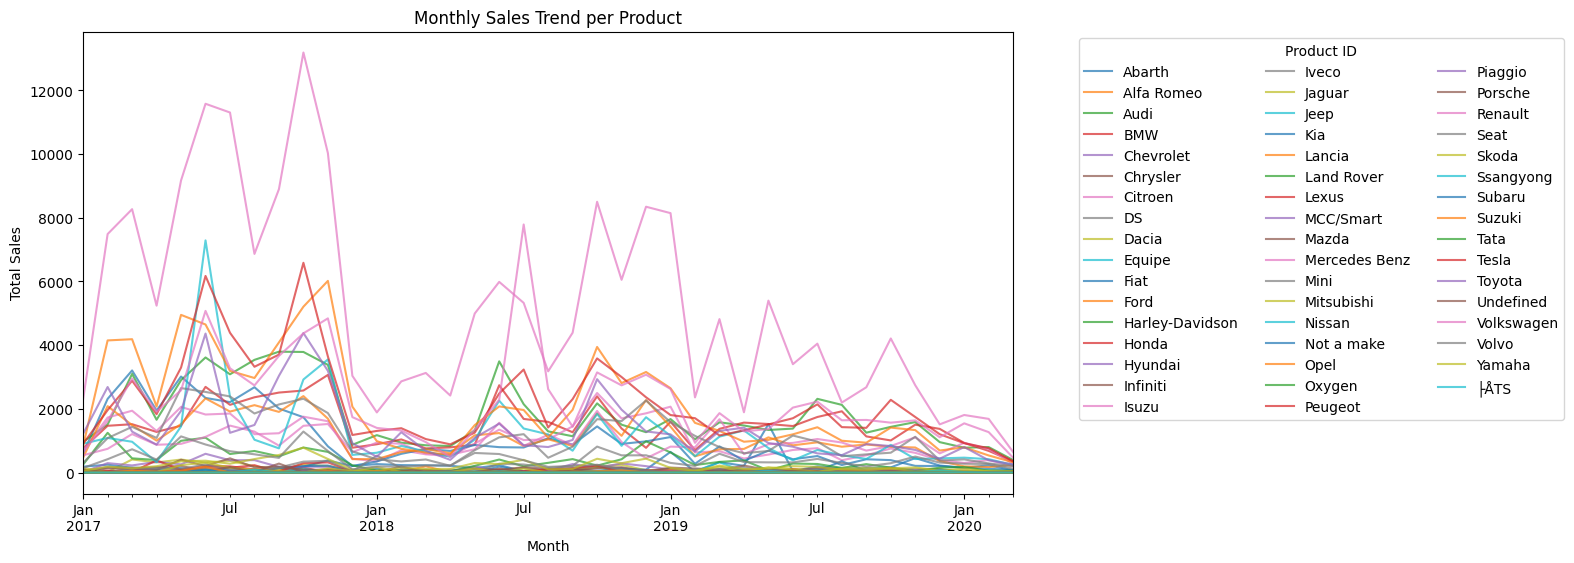

In [49]:
# Aggregate sales per product per month
all_transactions['month'] = all_transactions['date'].dt.to_period('M')
monthly_sales = all_transactions.groupby(['month', 'product_id']).size().unstack(fill_value=0)

# Plot sales trends
plt.figure(figsize=(12, 6))
monthly_sales.plot(ax=plt.gca(), alpha=0.7)
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.title("Monthly Sales Trend per Product")
plt.legend(loc='upper right', bbox_to_anchor=(1.60, 1), title='Product ID', ncol=3)
plt.show()

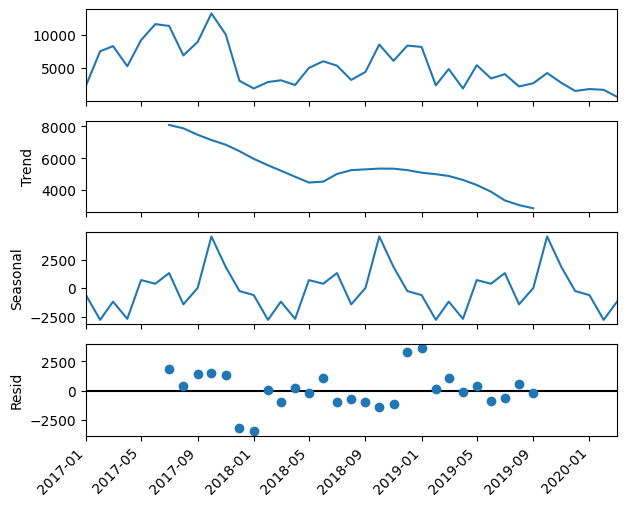

In [50]:
# Select a product to analyze (e.g., top-selling product)
product_id = all_transactions['product_id'].value_counts().idxmax()

# Filter time series data for this product
product_sales = all_transactions[all_transactions['product_id'] == product_id].groupby('month').size()

# Convert Period to Timestamp
product_sales.index = product_sales.index.to_timestamp()

# Apply seasonal decomposition
decomposition = seasonal_decompose(product_sales, model='additive', period=12)

# Plot decomposition
decomposition.plot()
plt.xticks(rotation=45, ha='right')
plt.show()